In [17]:
from itk import gio_read_dict, hist, plt_latex
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import trange
plt_latex()

In [10]:
data_dir = '/home/isultan/data/AlphaQ/updated_tree_nodes/'
steps = sorted([int(f.split('.')[2]) for f in os.listdir(data_dir) if '#' not in f])
fname = lambda s : data_dir + '09_03_2019.AQ.{}.treenodes'.format(s)

In [11]:
# sum(Mp)/MN for every node N with at least 1 progenitor p, in mass bins of MN
# sum(Mp)/MN for every node N with at least 1 fragment progenitor p, in mass bins of MN

cols = ['tree_node_index', 'desc_node_index', 'fof_halo_mass', 'fof_halo_tag']
sumMp = np.array([], dtype=np.float32)
MN = np.array([], dtype=np.float32)
hasFragment = np.array([], dtype=bool)
countStep = np.array([], dtype=np.int32)

mt = None
for s, s_next in zip(steps[:-1], steps[1:]):
    #readin
    if not mt:
        mt = gio_read_dict( fname(s), cols )
        
    mt_next = gio_read_dict( fname(s_next), cols )
    
    fragmask = mt['fof_halo_tag']<0
    
    isin = np.isin(mt['desc_node_index'], mt_next['tree_node_index'])
    arst = np.argsort(mt['desc_node_index'][isin])
    mt_prog = { k:mt[k][isin][arst] for k in cols }
    
    vals, idx1, idx2 = np.intersect1d(mt_prog['desc_node_index'], mt_next['tree_node_index'], assume_unique=False, return_indices=True)
    
    vals2, ind, inv, cnts = np.unique(mt_prog['desc_node_index'], return_inverse=True, return_counts=True, return_index=True)
    
    MN = np.append( MN, mt_next['fof_halo_mass'][idx2] )
    
    c = np.r_[0, np.cumsum(cnts)[:-1]]
    sumMp = np.append( sumMp, np.add.reduceat(mt_prog['fof_halo_mass'], c) )
    hasFragment = np.append( hasFragment, np.bitwise_or.reduceat((mt_prog['fof_halo_tag']<0), c) )
    
    countStep = np.append( countStep, len(vals) )
    
    mt = { k:mt_next[k].copy() for k in cols }

100%|██████████| 98/98 [10:57<00:00, 10.34s/it]


/home/isultan/projects/itk/itk.py:78: RuntimeWarning: invalid value encountered in true_divide
  cnts =  np.true_divide(cnts, np.sum(cnts))


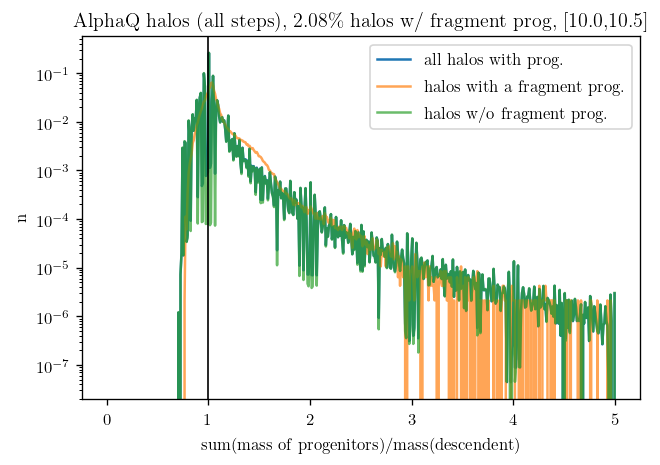

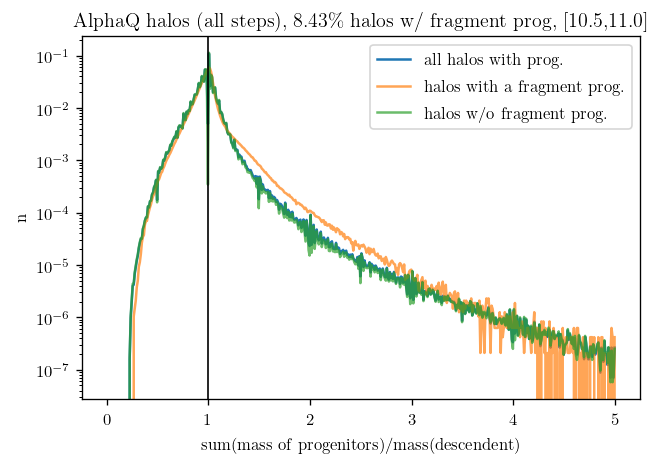

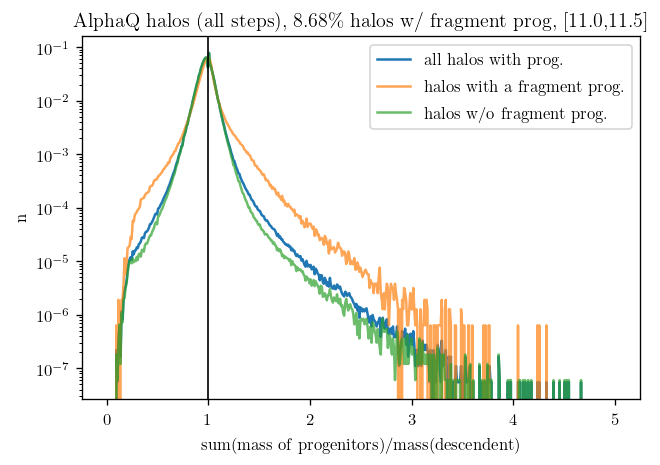

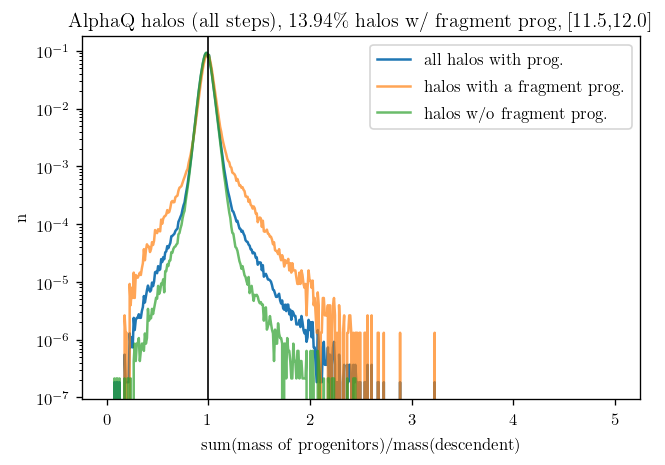

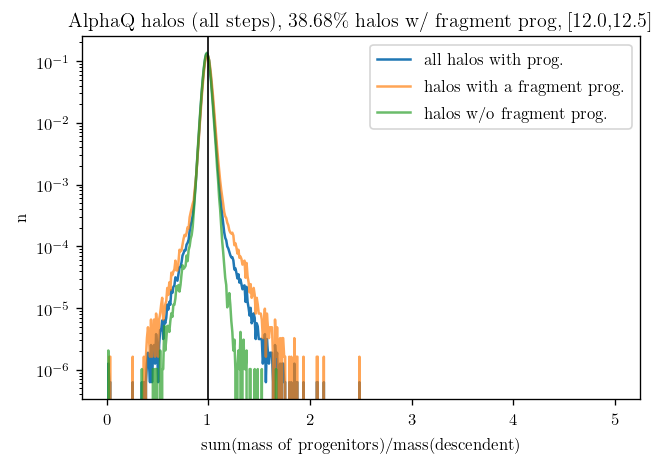

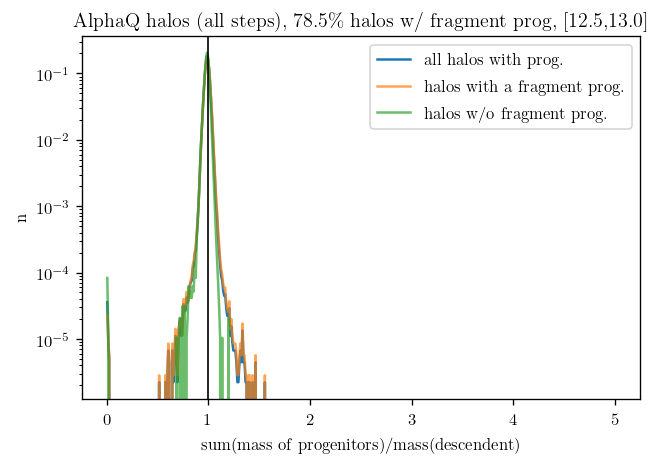

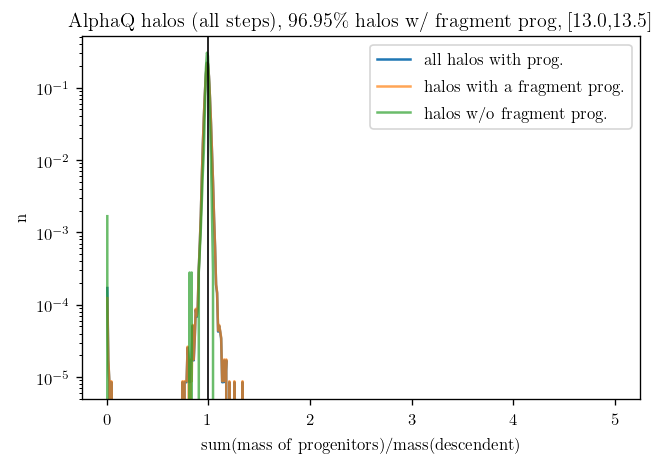

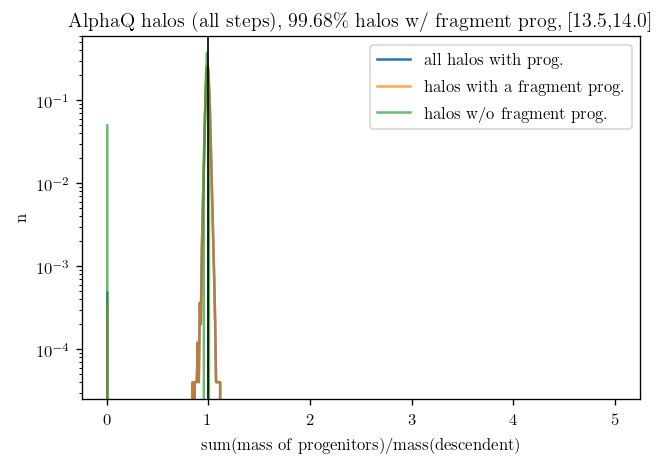

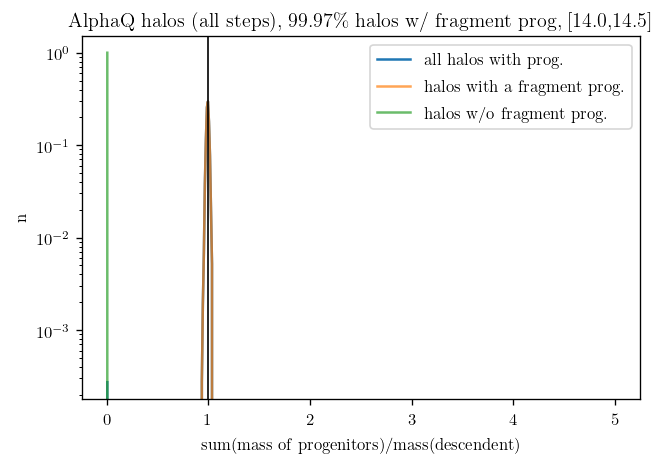

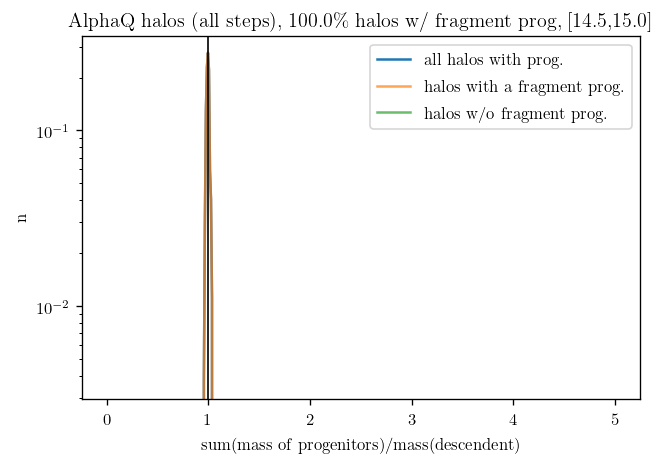

In [24]:
bins = np.arange(10, 15.5, 0.5)
for i in range(len(bins)-1):
    M1, M2 = 10**bins[i], 10**bins[i+1]
    plt.figure()
    hist( (sumMp/MN)[(M1<=MN)&(MN<=M2)], label='all halos with prog.', range=(0,5), normed=True, normCnts=True, plotOptions='-' )
    hist( (sumMp/MN)[(M1<=MN)&(MN<=M2)&hasFragment], label='halos with a fragment prog.', alpha=0.7, range=(0,5), normed=True, normCnts=True, plotOptions='-' )
    hist( (sumMp/MN)[(M1<=MN)&(MN<=M2)&(np.invert(hasFragment))], label='halos w/o fragment prog.', alpha=0.7, range=(0,5), normed=True, normCnts=True, plotOptions='-' )

    rf = np.true_divide(np.sum((M1<=MN)&(MN<=M2)&hasFragment), np.sum((M1<=MN)&(MN<=M2)))*100
    
    plt.yscale('log');
    plt.axvline(x=1, color='k', linewidth=1);
    plt.xlabel('$\mathrm{sum(mass\ of\ progenitors)/mass(descendent)}$')
    plt.ylabel('n')
    plt.title('AlphaQ halos (all steps), {}\% halos w/ fragment prog, [{},{}]'.format(round(rf,2), bins[i],bins[i+1]));
    plt.legend()
#     plt.savefig('prog_desc_mass_ratio_realandfrag_samexlim0_percentfrag_{}_{}.png'.format(bins[i],bins[i+1]))

In [18]:
Mbin = []
fragnum = []
descnum = []

bins = np.arange(10, 15.5, 0.1)
for i in range(len(bins)-1):
    M1, M2 = 10**bins[i], 10**bins[i+1]
    mask = (M1<=MN)&(MN<M2)
    fragnum.append( np.sum(hasFragment[mask]) )
    descnum.append( np.sum(mask) )
    Mbin.append( bins[i] )

Text(0.5,1,'Descendent halos mass distribution (AlphaQ all steps)')

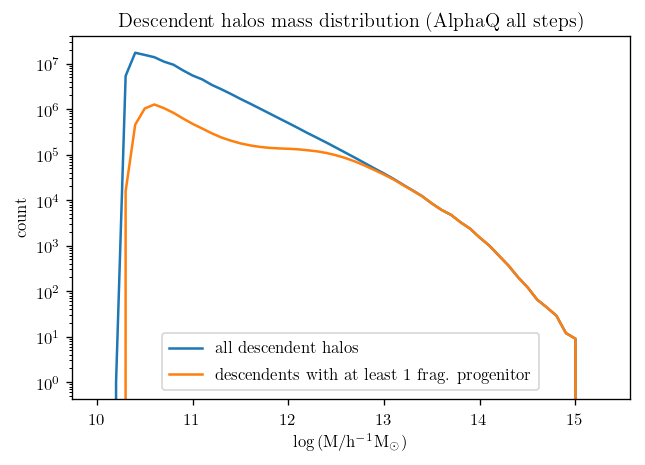

In [20]:
plt.plot(Mbin, descnum, label='all descendent halos')
plt.plot(Mbin, fragnum, label='descendents with at least 1 frag. progenitor')
plt.yscale('log')
plt.ylabel('count')
plt.xlabel('$\log\mathrm{(M/h^{-1}M_{\odot})}$')
plt.legend()
plt.title('Descendent halos mass distribution (AlphaQ all steps)')

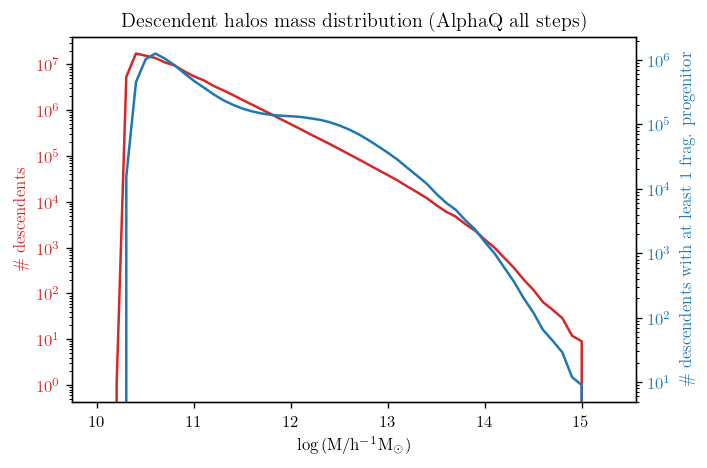

In [21]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('$\log\mathrm{(M/h^{-1}M_{\odot})}$')
ax1.set_ylabel('\# descendents', color=color)
ax1.plot(Mbin, descnum, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.semilogy()

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('\# descendents with at least 1 frag. progenitor', color=color)
ax2.plot(Mbin, fragnum, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.semilogy()

ax1.set_title('Descendent halos mass distribution (AlphaQ all steps)')
fig.tight_layout() 

/home/isultan/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


Text(0.5,1,'AlphaQ (all steps)')

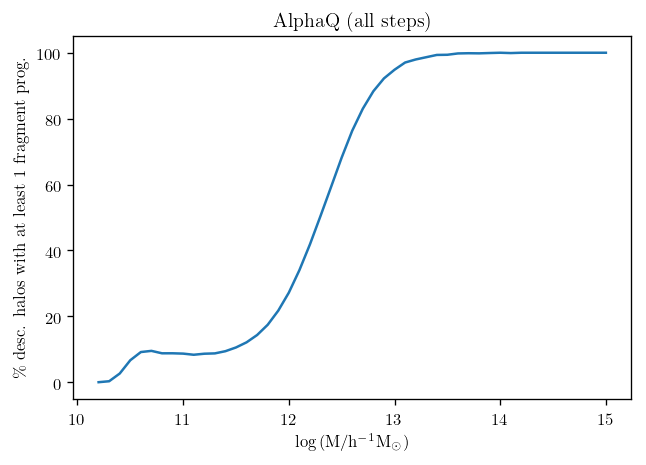

In [23]:
plt.plot(Mbin, np.true_divide(fragnum, descnum)*100)
plt.ylabel('\% desc. halos with at least 1 fragment prog.')
plt.xlabel('$\log\mathrm{(M/h^{-1}M_{\odot})}$')
plt.title('AlphaQ (all steps)')